In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wrangle import *

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = acquire_zillow()

In [3]:
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,propertylandusedesc,transactiondate
0,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,Single Family Residential,2017-07-21
1,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,Single Family Residential,2017-06-23
2,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,Single Family Residential,2017-06-30
3,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,Single Family Residential,2017-06-01
4,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0,Single Family Residential,2017-08-23


In [4]:
df.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built', 'taxamount',
       'fips', 'propertylandusedesc', 'transactiondate'],
      dtype='object')

In [16]:
df.fips.value_counts()

6037.0    13373
6059.0     6293
6111.0     2091
Name: fips, dtype: int64

In [5]:
# Converting fips to actual county name

df['county'] = df['fips'].replace({6037:'Los Angeles',6059:'Orange',6111:'Ventura'})

In [6]:
# Creating tax_rate column

df['tax_rate'] = (df['taxamount']/df['tax_value'])
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,propertylandusedesc,transactiondate,county,tax_rate
0,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,Single Family Residential,2017-07-21,Los Angeles,0.012809
1,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,Single Family Residential,2017-06-23,Los Angeles,0.017045
2,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,Single Family Residential,2017-06-30,Los Angeles,0.015270
3,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,Single Family Residential,2017-06-01,Orange,0.011153
4,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0,Single Family Residential,2017-08-23,Los Angeles,0.013064


In [7]:
# Remove Outliers

col_list = ['bedrooms','bathrooms','area','tax_value','taxamount','tax_rate']
df = remove_outliers(df,1.5,col_list)

In [8]:
# Imputing year_built with most_frequent value

imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df[['year_built']])
df[['year_built']] = imputer.transform(df[['year_built']])

In [20]:
df.isnull().any()

bedrooms               False
bathrooms              False
area                   False
tax_value              False
year_built             False
taxamount              False
fips                   False
propertylandusedesc    False
transactiondate        False
county                 False
tax_rate               False
dtype: bool

In [9]:
df.shape

(21757, 11)

In [11]:
# Creating a dataframe with county and tax_rate
tax_data = pd.DataFrame({'county':df.county,'tax_rate':df.tax_rate})
tax_data

,county,tax_rate
0,Los Angeles,0.012809
1,Los Angeles,0.017045
2,Los Angeles,0.015270
3,Orange,0.011153
4,Los Angeles,0.013064
...,...,...
28141,Los Angeles,0.014354
28142,Ventura,0.014285
28144,Orange,0.011916
28145,Orange,0.013676


In [12]:
tax_data.describe()

,tax_rate
count,21757.000000
mean,0.012534
std,0.001512
min,0.008702
25%,0.011597
50%,0.012284
75%,0.013211
max,0.017049


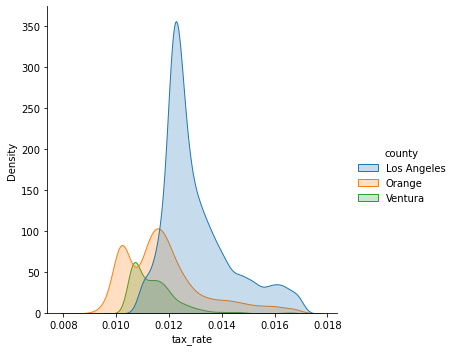

In [13]:
# Plotting distribution of tax_rate by county

sns.displot(tax_data, x="tax_rate", hue="county", kind='kde',fill=True)
plt.show()

In [21]:
df.corr()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,tax_rate
bedrooms,1.000000,0.577396,0.603854,0.198695,0.365316,0.202016,0.157455,-0.049573
bathrooms,0.577396,1.000000,0.774889,0.353345,0.552342,0.353356,0.143566,-0.135436
area,0.603854,0.774889,1.000000,0.429382,0.488199,0.425962,0.152884,-0.158650
tax_value,0.198695,0.353345,0.429382,1.000000,0.256820,0.983666,0.121563,-0.516220
year_built,0.365316,0.552342,0.488199,0.256820,1.000000,0.255531,0.319565,-0.108053
taxamount,0.202016,0.353356,0.425962,0.983666,0.255531,1.000000,0.058524,-0.392636
fips,0.157455,0.143566,0.152884,0.121563,0.319565,0.058524,1.000000,-0.363134
tax_rate,-0.049573,-0.135436,-0.158650,-0.516220,-0.108053,-0.392636,-0.363134,1.000000


In [23]:
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,propertylandusedesc,transactiondate,county,tax_rate
0,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,Single Family Residential,2017-07-21,Los Angeles,0.012809
1,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,Single Family Residential,2017-06-23,Los Angeles,0.017045
2,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,Single Family Residential,2017-06-30,Los Angeles,0.015270
3,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,Single Family Residential,2017-06-01,Orange,0.011153
4,3.0,2.0,1491.0,107110.0,1955.0,1399.27,6037.0,Single Family Residential,2017-08-23,Los Angeles,0.013064


Is there a trend with taxamount and the transactiondate

In [24]:
tax_and_date = pd.DataFrame({'tax_value':df.tax_value,'transactiondate':df.transactiondate})
tax_and_date

,tax_value,transactiondate
0,205123.0,2017-07-21
1,136104.0,2017-06-23
2,35606.0,2017-06-30
3,880456.0,2017-06-01
4,107110.0,2017-08-23
...,...,...
28141,200000.0,2017-08-31
28142,141877.0,2017-08-31
28144,465999.0,2017-08-31
28145,852813.0,2017-08-31


In [40]:
tax_and_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21757 entries, 0 to 28147
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tax_value        21757 non-null  float64
 1   transactiondate  21757 non-null  object 
dtypes: float64(1), object(1)
memory usage: 509.9+ KB


In [51]:
# Create a month column:
def label_month(tax_and_date):
    if tax_and_date['transactiondate'] == '****-05-**':
        return 'May'
    if tax_and_date['transactiondate'] == '****-06-**':
        return 'June'
    if tax_and_date['transactiondate'] == '****-07-**':
        return 'July'
    if tax_and_date['transactiondate'] == '****-08-**':
        return 'August'

In [54]:
tax_and_date.apply(lambda tax_and_date: label_month(tax_and_date), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
28141    None
28142    None
28144    None
28145    None
28147    None
Length: 21757, dtype: object

In [64]:
df[df.transactiondate.str.match('2017-05')]

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,propertylandusedesc,transactiondate,county,tax_rate
14,3.0,2.0,1668.0,196483.0,1976.0,2376.34,6059.0,Single Family Residential,2017-05-19,Orange,0.012094
15,3.0,2.5,1653.0,605000.0,1992.0,6185.28,6059.0,Single Family Residential,2017-05-01,Orange,0.010224
16,3.0,1.0,879.0,141875.0,1953.0,2015.78,6059.0,Single Family Residential,2017-05-18,Orange,0.014208
17,3.0,2.0,1108.0,486866.0,1953.0,5990.50,6037.0,Single Family Residential,2017-05-17,Los Angeles,0.012304
18,3.0,2.0,1947.0,388478.0,1923.0,4784.07,6037.0,Single Family Residential,2017-05-11,Los Angeles,0.012315
...,...,...,...,...,...,...,...,...,...,...,...
7227,3.0,1.0,963.0,147556.0,1928.0,1874.58,6059.0,Single Family Residential,2017-05-31,Orange,0.012704
7228,2.0,1.0,873.0,192820.0,1941.0,2894.40,6037.0,Single Family Residential,2017-05-31,Los Angeles,0.015011
7229,2.0,1.0,956.0,62289.0,1953.0,972.19,6037.0,Single Family Residential,2017-05-31,Los Angeles,0.015608
7230,3.0,2.0,1138.0,190442.0,1959.0,2439.90,6059.0,Single Family Residential,2017-05-31,Orange,0.012812
